In [1]:
%load_ext rpy2.ipython

In [2]:
from IPython.display import HTML
HTML('''<script>
var code_show_err = false;
var code_toggle_err = function() {
    var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
    var stderr = Array.from(stderrNodes)
    if (code_show_err){
        stderr.forEach(ele => ele.style.display = 'block');
    } else {
        stderr.forEach(ele => ele.style.display = 'none');
    }
    code_show_err = !code_show_err
}
document.addEventListener('DOMContentLoaded', code_toggle_err);
</script>
To toggle on/off output_stderr, click <a onclick="javascript:code_toggle_err()">here</a>.''')

In [3]:
%%R
library(ggplot2)
library(DESeq2)
library(apeglm)
library(ggrepel)
library(dplyr)
library(org.Mm.eg.db)
library(PCAtools)
library(GEOquery)
library(fgsea)
library(stringr)
library(Seurat)
library(patchwork)
library(Matrix)
library(MAST)
library(umap)

R[write to console]: Загрузка требуемого пакета: S4Vectors

R[write to console]: Загрузка требуемого пакета: stats4

R[write to console]: Загрузка требуемого пакета: BiocGenerics

R[write to console]: 
Присоединяю пакет: ‘BiocGenerics’


R[write to console]: Следующие объекты скрыты от ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: Следующие объекты скрыты от ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


R[write to console]: 
Присоединяю пакет: ‘S4Vectors’


R[write to console]: Следующие объекты скрыты от ‘package:base’:

    expand.grid, I, unname


R[write to console]: Загрузка требуемого пакета


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject

R[write to console]: 
Присоединяю пакет: ‘Seurat’


R[write to console]: Следующий объект скрыт от ‘package:SummarizedExperiment’:

    Assays


R[write to console]: 
Присоединяю пакет: ‘Matrix’


R[write to console]: Следующий объект скрыт от ‘package:S4Vectors’:

    expand


R[write to console]: Загрузка требуемого пакета: SingleCellExperiment



#  Научиться извлекать названия сэмплов из строки

In [6]:
cd split

/Users/pavellebedev/Yandex.Disk.localized/Cloud_project/Project_2/split


In [8]:
%%R
split = read.table('GSE100067-GPL17021_split.txt')

In [9]:
%%R
head(split, n = 1)
rows = split['V4'][1,]
rows3 = split['V5'][1,]
rows2 = str_split_1(rows, '//')
rows4 = str_split_1(rows3, '//')

# Читаем таблицы с экспрессией

In [10]:
cd ..

/Users/pavellebedev/Yandex.Disk.localized/Cloud_project/Project_2


In [11]:
%%R
exp = read.csv("expression6.csv")

# Как запустить Десек с этими сэмплами

In [12]:
%%R
# create table for coldata in deseq
Comparison <- c(rep("A", length(rows2)), rep("B", length(rows4)))
df <- data.frame(Comparison)
rownames(df) = c(rows2,rows4)
df

           Comparison
GSM2670770          A
GSM2670771          A
GSM2670772          B
GSM2670765          B
GSM2670763          B
GSM2670764          B
GSM2670766          B
GSM2670769          B
GSM2670767          B
GSM2670768          B


In [14]:
%%R
# makedeseq
dds <- DESeqDataSetFromMatrix(countData = exp[c(rows2,rows4)],
                              colData = df,
                                  design= ~ Comparison)
dds <- DESeq(dds)
resultsNames(dds) # lists the coefficients
res <- results(dds)
head(res)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 2286 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



log2 fold change (MLE): Comparison B vs A 
Wald test p-value: Comparison B vs A 
DataFrame with 6 rows and 6 columns
   baseMean log2FoldChange     lfcSE      stat    pvalue      padj
  <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
1  314.3903     -0.1151018  0.337651 -0.340890 0.7331865  0.844906
2   69.6209      1.3964120  0.700969  1.992117 0.0463582  0.142453
3    8.1268      1.2662072  1.885222  0.671649 0.5018072  0.671944
4  154.8457     -0.0799346  0.464134 -0.172223 0.8632620  0.925130
5  164.9744      0.6461378  0.308865  2.091978 0.0364405  0.120939
6  166.3646      0.4845665  0.449782  1.077335 0.2813306  0.466261


### Сохраняем все log2FoldChange  в отдельный файл по одному пока что сравнению

In [10]:
%%R
save(result, file ="Deseq_res/1_1.rda")

### Сделаем цикл через все строки файла 

In [32]:
%%R
for (i in 1:nrow(split)) {
skip_to_next <- FALSE
tryCatch({    # miss errors and continue, if samplew are not in exp
rows = split['V4'][i,]
rows3 = split['V5'][i,]
rows2 = str_split_1(rows, '//')
rows4 = str_split_1(rows3, '//')
Comparison <- c(rep("A", length(rows2)), rep("B", length(rows4)))
df <- data.frame(Comparison)
rownames(df) = c(rows2,rows4)
# design = model.matrix(~Comparison, data = df) + колонки 1-2 с logfoldchange c более глубого уровня
dds <- DESeqDataSetFromMatrix(countData = dee[c(rows2,rows4)],
                              colData = df, design= ~ Comparison) #design = design
dds <- DESeq(dds)
resultsNames(dds) # lists the coefficients
res <- results(dds)
result = res$log2FoldChange
save(result, file = paste0("Deseq_res/1_", i, ".rda"))    
    
    
}, error = function(e) { skip_to_next <<- TRUE})
if(skip_to_next) { next }  

}


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 2137 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 1981 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved

### Сделаем петлю через все файлы папки

In [13]:
cd split

/Users/pavellebedev/Yandex.Disk.localized/Cloud_project/Project_2/split


In [14]:
%%R
folder <- file.path("split")
path = file.path(folder, fileName)

R[write to console]: Ошибка в as.vector(x, "character") :
  cannot coerce type 'closure' to vector of type 'character'




Ошибка в as.vector(x, "character") :
  cannot coerce type 'closure' to vector of type 'character'


RInterpreterError: Failed to parse and evaluate line 'folder <- file.path("split")\npath = file.path(folder, fileName)\n'.
R error message: 'Ошибка в as.vector(x, "character") :\n  cannot coerce type \'closure\' to vector of type \'character\''

In [15]:
%%R
path

standardGeneric for "path" defined from package "BiocGenerics"

function (object, ...) 
standardGeneric("path")
<bytecode: 0x14ee062e8>
<environment: 0x14ee05858>
Methods may be defined for arguments: object
Use  showMethods(path)  for currently available ones.


In [ ]:
%%R
Archs4 = read.csv("exp_cross.csv")
files<-list.files(path='split', pattern='.txt', full.names = FALSE)
for (fileName in files) {   
    folder <- file.path("split")
    path = file.path(folder, fileName)
    skip_to_next <- FALSE
    tryCatch({ 
        split <-  read.table(path)
        for (i in 1:nrow(split)) {
            skip_to_next <- FALSE
            tryCatch({    # miss errors and continue, if samplew are not in exp
                rows = split['V4'][i,]
                rows3 = split['V5'][i,]
                rows2 = str_split_1(rows, '//')
                rows4 = str_split_1(rows3, '//')
                Comparison <- c(rep("A", length(rows2)), rep("B", length(rows4)))
                df <- data.frame(Comparison)
                rownames(df) = c(rows2,rows4)
                dds <- DESeqDataSetFromMatrix(countData = Archs4[c(rows2,rows4)],
                                              colData = df, design= ~ Comparison)
                dds <- DESeq(dds)
                resultsNames(dds) # lists the coefficients
                res <- results(dds)
                result = res$log2FoldChange
                save(result, file = paste0("Deseq_res/", fileName, "_", i, ".rda"))        
        }, error = function(e) { skip_to_next <<- TRUE})
        if(skip_to_next) { next }
            }
    }, error = function(e) { skip_to_next <<- TRUE})
    if(skip_to_next) { next }
    }



R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 2173 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 2074 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved

## Сделаем то же самое, но сохраним в rda переменные с полным результатом десек анализа -  dds

In [155]:
cd ..

/home/paul/Yandex.Disk/Cloud_project/Project_2


In [146]:
%%R
Archs4 = read.csv("exp_cross.csv")

In [152]:
%%R
files<-list.files(path='split', pattern='.txt', full.names = FALSE)

In [158]:
%%R
for (fileName in files) {   
    folder <- file.path("split")
    path = file.path(folder, fileName)
    skip_to_next <- FALSE
    tryCatch({ 
        split <-  read.table(path)
        for (i in 1:nrow(split)) {
            skip_to_next <- FALSE
            tryCatch({    # miss errors and continue, if samplew are not in exp
                rows = split['V4'][i,]
                rows3 = split['V5'][i,]
                rows2 = str_split_1(rows, '//')
                rows4 = str_split_1(rows3, '//')
                Comparison <- c(rep("A", length(rows2)), rep("B", length(rows4)))
                df <- data.frame(Comparison)
                rownames(df) = c(rows2,rows4)
                dds <- DESeqDataSetFromMatrix(countData = Archs4[c(rows2,rows4)],
                                              colData = df, design= ~ Comparison, tidy = TRUE)
                dds <- DESeq(dds)
                result = dds
                save(result, file = paste0("Deseq_res2/", fileName, "_", i, ".rda"))        
        }, error = function(e) { skip_to_next <<- TRUE})
        if(skip_to_next) { next }
            }
    }, error = function(e) { skip_to_next <<- TRUE})
    if(skip_to_next) { next }
}



In [159]:

%%R
Archs4 = read.csv("exp_cross.csv")
files<-list.files(path='split', pattern='.txt', full.names = FALSE)
for (fileName in files) {   
    folder <- file.path("split")
    path = file.path(folder, fileName)
    skip_to_next <- FALSE
    tryCatch({ 
        split <-  read.table(path)
        for (i in 1:nrow(split)) {
            skip_to_next <- FALSE
            tryCatch({    # miss errors and continue, if samplew are not in exp
                rows = split['V4'][i,]
                rows3 = split['V5'][i,]
                rows2 = str_split_1(rows, '//')
                rows4 = str_split_1(rows3, '//')
                Comparison <- c(rep("A", length(rows2)), rep("B", length(rows4)))
                df <- data.frame(Comparison)
                rownames(df) = c(rows2,rows4)
                dds <- DESeqDataSetFromMatrix(countData = Archs4[c(rows2,rows4)],
                                              colData = df, design= ~ Comparison)
                save(dds, file = paste0("Deseq_res3/", fileName, "_", i, ".rda"))        
        }, error = function(e) { skip_to_next <<- TRUE})
        if(skip_to_next) { next }
            }
    }, error = function(e) { skip_to_next <<- TRUE})
    if(skip_to_next) { next }
    }



## Учимся считывать dds из всех файлов в один для общего pca

In [ ]:
%%R
files<-list.files(path='Deqseq_res2', pattern='.rda', full.names = FALSE)
for (fileName in files) {   
    

In [160]:
cd 'Deseq_res3/'

/home/paul/Yandex.Disk/Cloud_project/Project_2/Deseq_res3


In [168]:
%%R
load('GSE98168-GPL17021_split.txt_1.rda')
head(dds2)

class: DESeqDataSet 
dim: 6 7 
metadata(1): version
assays(4): counts mu H cooks
rownames: NULL
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(7): GSM2588872 GSM2588870 ... GSM2588875 GSM2588876
colData names(2): Comparison sizeFactor


In [128]:
%%R
load('GSE100067-GPL17021_split.txt_1.rda')

In [129]:
%%R
result_prime = result

In [133]:
%%R
load('Deseq_res2/GSE100067-GPL17021_split.txt_2.rda')

In [134]:
%%R
print(head(result))
print(head(result_prime))

class: DESeqDataSet 
dim: 6 14 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames: NULL
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(14): GSM2670776 GSM2670773 ... GSM2670767 GSM2670768
colData names(3): Comparison sizeFactor replaceable
class: DESeqDataSet 
dim: 6 10 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames: NULL
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(10): GSM2670770 GSM2670771 ... GSM2670767 GSM2670768
colData names(3): Comparison sizeFactor replaceable


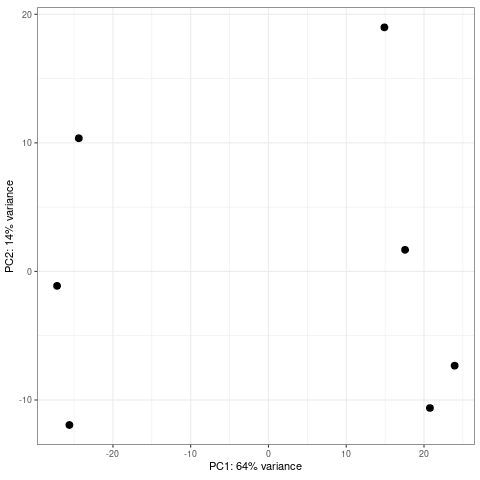

In [167]:
%%R
vst2 <- varianceStabilizingTransformation(dds)
data = plotPCA(vst2, intgroup=c("Comparison"), ntop=nrow(vst), returnData = TRUE)
percentVar <- round(100 * attr(data, "percentVar"))
p<- ggplot(data, aes(PC1, PC2)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance"))
p + theme_bw() + theme(aspect.ratio = 1)

In [135]:
%%R
mcols(result) <- NULL
result_prime<- cbind(result, result_prime)

In [136]:
%%R
head(result_prime)

class: DESeqDataSet 
dim: 6 24 
metadata(2): version version
assays(6): counts mu ... replaceCounts replaceCooks
rownames: NULL
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(24): GSM2670776 GSM2670773 ... GSM2670767 GSM2670768
colData names(3): Comparison sizeFactor replaceable


In [173]:
cd ..

/home/paul/Yandex.Disk/Cloud_project/Project_2


## Считываем все десек матрицы в одну переменную

In [174]:
%%R
files<-list.files(path='Deseq_res3', pattern='.rda', full.names = TRUE)
load('GSE100067-GPL17021_split-Copy1.txt_1.rda')
result_prime = dds
for (file in files) {  
    load(file)
    mcols(dds) <- NULL
    result_prime <- cbind(result_prime, dds)
}


In [175]:
%%R
head(result_prime)

class: DESeqDataSet 
dim: 6 4404 
metadata(455): version version ... version version
assays(1): counts
rownames: NULL
rowData names(0):
colnames(4404): GSM2670770 GSM2670771 ... GSM2652260 GSM2652261
colData names(1): Comparison


In [178]:
%%R
result_prime2 = DESeq(result_prime)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 6832 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing



In [179]:
%%R
head(result_prime2)

class: DESeqDataSet 
dim: 6 4404 
metadata(455): version version ... version version
assays(6): counts mu ... replaceCounts replaceCooks
rownames: NULL
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(4404): GSM2670770 GSM2670771 ... GSM2652260 GSM2652261
colData names(3): Comparison sizeFactor replaceable


In [180]:
%%R
head(data)

                 PC1        PC2 group Comparison       name
GSM2670770 -82.57659 -41.246528     A          A GSM2670770
GSM2670771 -76.53847 -34.112800     A          A GSM2670771
GSM2670772  21.81413   9.869034     B          B GSM2670772
GSM2670765 -16.02762  -9.014112     B          B GSM2670765
GSM2670763 -15.06024   5.781092     B          B GSM2670763
GSM2670764 -37.62673   2.557776     B          B GSM2670764


## Делаем общие РСА по всем десекам

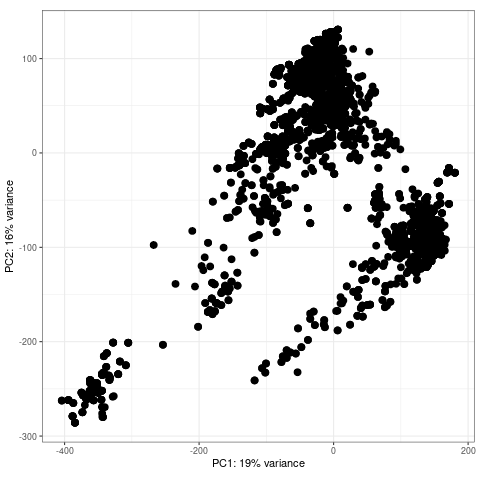

In [176]:
%%R
vst <- varianceStabilizingTransformation(result_prime)
data = plotPCA(vst, intgroup=c("Comparison"), ntop=nrow(vst), returnData = TRUE)
percentVar <- round(100 * attr(data, "percentVar"))
p<- ggplot(data, aes(PC1, PC2)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance"))
p + theme_bw() + theme(aspect.ratio = 1)

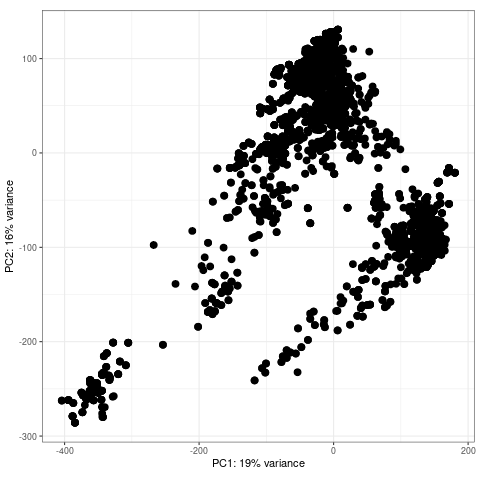

In [181]:
%%R
vst <- varianceStabilizingTransformation(result_prime2)
data = plotPCA(vst, intgroup=c("Comparison"), ntop=nrow(vst), returnData = TRUE)
percentVar <- round(100 * attr(data, "percentVar"))
p<- ggplot(data, aes(PC1, PC2)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance"))
p + theme_bw() + theme(aspect.ratio = 1)

## Делаем Umap

In [216]:
%%R
normalized_counts <- assay(vst) %>%
  t()
umap_results <- umap::umap(normalized_counts)


In [222]:
%%R
umap_plot_df <- data.frame(umap_results$layout) 

In [223]:
%%R
head(umap_plot_df)

                  X1        X2
GSM2670770 -12.45694 -4.264159
GSM2670771 -12.45135 -4.246016
GSM2670772 -12.46738 -4.274286
GSM2670765 -12.44953 -4.256926
GSM2670763 -12.46381 -4.270350
GSM2670764 -12.44105 -4.246046


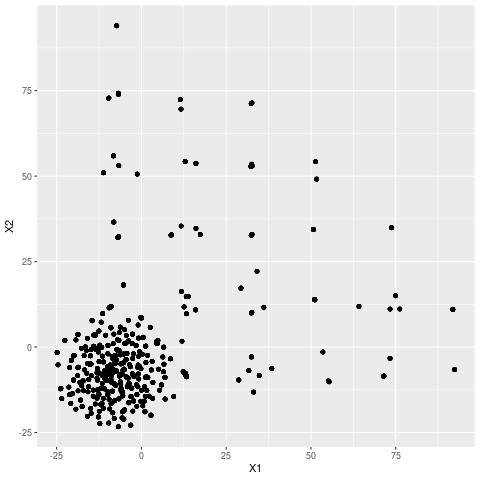

In [224]:
%%R
ggplot(
  umap_plot_df,
  aes(
    x = X1,
    y = X2
  )
) +
  geom_point()

In [6]:
pwd

'/Users/pavellebedev/Yandex.Disk.localized/Cloud_project/Project_2'

In [7]:
cd 'Deseq_res'

/Users/pavellebedev/Yandex.Disk.localized/Cloud_project/Project_2/Deseq_res


In [8]:
%%R
load('GSE100067-GPL17021_split.txt_1.rda')

In [9]:
%%R
head(result)

[1] 1.9047813        NA 0.8046991 1.6005374 2.3982436 0.4044271


# Переделаем со следующими параметрами:
- сырые каунты берем из ARCHS4
- на входпоступаем матрица из строки - гены, колонки - пары сравнения, ячейки - logfoldchange

In [39]:
%%R
Archs4 = read.csv("expression6.csv")
files<-list.files(path='split', pattern='.txt', full.names = FALSE)
for (fileName in files) {   
    folder <- file.path("split")
    path = file.path(folder, fileName)
    skip_to_next <- FALSE
    tryCatch({ 
        split <-  read.table(path)
        for (i in 1:nrow(split)) {
            skip_to_next <- FALSE
            tryCatch({    # miss errors and continue, if samplew are not in exp
                rows = split['V4'][i,]
                rows3 = split['V5'][i,]
                rows2 = str_split_1(rows, '//')
                rows4 = str_split_1(rows3, '//')
                Comparison <- c(rep("A", length(rows2)), rep("B", length(rows4)))
                df <- data.frame(Comparison)
                rownames(df) = c(rows2,rows4)
                dds <- DESeqDataSetFromMatrix(countData = Archs4[c(rows2,rows4)],
                                              colData = df, design= ~ Comparison)
                dds <- DESeq(dds)
                resultsNames(dds) # lists the coefficients
                res <- results(dds)
                result = res$log2FoldChange
                rows = str_replace_all(rows, '//', '_')
                rows3 = str_replace_all(rows3, '//', '_')
                result = c( paste0(fileName, "_", i), result)
                save(result, file = paste0('Deseq_res5/', fileName, "_", i, ".rda"))        
        }, error = function(e) { skip_to_next <<- TRUE})
        if(skip_to_next) { next }
            }
    }, error = function(e) { skip_to_next <<- TRUE})
    if(skip_to_next) { next }
    }


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 2286 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

R[write to console]: estimating dispersions

R[write to console]: fitting model and testing

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: -- replacing outliers and refitting for 2196 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved

## Пробы

In [67]:
cd 'split'

/Users/pavellebedev/Yandex.Disk.localized/Cloud_project/Project_2/split


In [60]:
%%R
split <-  read.table('GSE100316-GPL15103_split.txt')

In [37]:
%%R
rows3

[1] "GSM2670772//GSM2670765//GSM2670763//GSM2670764//GSM2670766//GSM2670769//GSM2670767//GSM2670768"


In [61]:
%%R
head(split, n = 1)
rows = split['V4'][1,]
rows3 = split['V5'][1,]
rows2 = str_split_1(rows, '//')
rows4 = str_split_1(rows3, '//')

In [65]:
%%R
# create table for coldata in deseq
Comparison <- c(rep("A", length(rows2)), rep("B", length(rows4)))
df <- data.frame(Comparison)
rownames(df) = c(rows2,rows4)
df

           Comparison
GSM2677742          A
GSM2677743          A
GSM2677740          B
GSM2677741          B


In [75]:
cd ..

/Users/pavellebedev/Yandex.Disk.localized/Cloud_project/Project_2


In [4]:
pwd

'/Users/pavellebedev/Yandex.Disk.localized/Cloud_project/Project_2'

In [18]:
%%R
archs = read.csv("expression6.csv")

In [68]:
%%R
# makedeseq
dds <- DESeqDataSetFromMatrix(countData = archs[c(rows2,rows4)],
                              colData = df,
                                  design= ~ Comparison)
dds <- DESeq(dds)
resultsNames(dds) # lists the coefficients
res <- results(dds)

R[write to console]: Ошибка в h(simpleError(msg, call)) :
  ошибка при оценке аргумента 'x' при выборе метода для функции 'ncol': выбраны не определенные колонки




Ошибка в h(simpleError(msg, call)) :
  ошибка при оценке аргумента 'x' при выборе метода для функции 'ncol': выбраны не определенные колонки


RInterpreterError: Failed to parse and evaluate line '# makedeseq\ndds <- DESeqDataSetFromMatrix(countData = archs[c(rows2,rows4)],\n                              colData = df,\n                                  design= ~ Comparison)\ndds <- DESeq(dds)\nresultsNames(dds) # lists the coefficients\nres <- results(dds)\n'.
R error message: "Ошибка в h(simpleError(msg, call)) :\n  ошибка при оценке аргумента 'x' при выборе метода для функции 'ncol': выбраны не определенные колонки"

In [69]:
%%R
result = res$log2FoldChange

In [77]:
%%R
head(result, 6)

[1] -0.11510176  1.39641203  1.26620724 -0.07993458  0.64613781  0.48456646


In [78]:
%%R
result2 = c( paste0(rows, "-", rows3), result)

In [71]:
%%R
rows = str_replace_all(rows, '//', '_')

In [72]:
%%R
rows3 = str_replace_all(rows3, '//', '_')

In [73]:
%%R
rows3

[1] "GSM2677740_GSM2677741"


In [76]:
%%R
save(result, file = paste0('Deseq_res4/', rows, "-", rows3, ".rda"))

## Строим pca по-новому

In [4]:
%%R
library('FactoMineR')
library('ade4')
library('amap')

R[write to console]: 
Присоединяю пакет: ‘ade4’


R[write to console]: Следующий объект скрыт от ‘package:FactoMineR’:

    reconst


R[write to console]: Следующий объект скрыт от ‘package:GenomicRanges’:

    score


R[write to console]: Следующий объект скрыт от ‘package:BiocGenerics’:

    score


R[write to console]: 
Присоединяю пакет: ‘amap’


R[write to console]: Следующий объект скрыт от ‘package:PCAtools’:

    pca




In [4]:
%%R
files<-list.files(path='Deseq_res5', pattern='.rda', full.names = TRUE)
load('GSE100067-GPL17021_split.txt_1.rda')
df <- data.frame(result)
df = df[,-1]
for (file in files) {  
    load(file)
    df <- cbind(df, result)
}
names(df) = df[1, ]
df = df[-c(1), ]

In [5]:
%%R

library(Hmisc) #work with missing values
df <- impute(df, fun = 0) # replace missing values
df <- as.data.frame(apply(df, 2, as.numeric)) # all into numeric

R[write to console]: 
Присоединяю пакет: ‘Hmisc’


R[write to console]: Следующий объект скрыт от ‘package:MAST’:

    impute


R[write to console]: Следующий объект скрыт от ‘package:SeuratObject’:

    Key


R[write to console]: Следующий объект скрыт от ‘package:Seurat’:

    Key


R[write to console]: Следующий объект скрыт от ‘package:AnnotationDbi’:

    contents


R[write to console]: Следующие объекты скрыты от ‘package:dplyr’:

    src, summarize


R[write to console]: Следующий объект скрыт от ‘package:Biobase’:

    contents


R[write to console]: Следующие объекты скрыты от ‘package:base’:

    format.pval, units




In [6]:
%%R
df$Means <-apply(df,1,mean)

In [7]:
%%R
df = df[order(df$Means, decreasing = TRUE),]

In [8]:
%%R
df = df[1:10000,]

In [9]:
%%R
library("dplyr")
df <-subset(df, select = -c(Means))

In [10]:
%%R
df_t = t(df)

In [10]:
#%%R
#df_t[is.na(df_t)] = mean(df_t, na.rm = TRUE)

In [11]:
%%R
pca = prcomp(df_t, center = FALSE, scale = FALSE, na.action = na.omit)

In [74]:
%%R
head(pca_data)

      Names        X.X       X.Y
7293   7293 12.3837909 -1.803544
8168   8168  2.8685586 -2.389592
7383   7383 -0.5650522  4.263411
8452   8452 -0.5650522  4.263411
23912 23912 11.1881100  5.742677
11079 11079  8.0773057 -3.372789


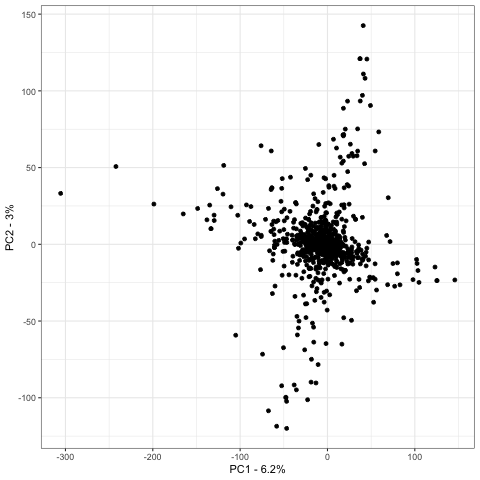

In [12]:
%%R
library(ggplot2)

#
X = pca$x[,1]
Y = pca$x[,2]
pca_data <- data.frame(Names = rownames(pca$x), + X, + Y)
pca_var <- pca$sdev^2
pca_var_per <- round(pca_var / sum(pca_var) * 100, 1)
# Plot
p <- ggplot(data = pca_data, aes(x = X, y = Y))
p <- p + geom_point()
p <- p + xlab(paste0("PC1 - ", pca_var_per[1], "%"))
p <- p + ylab(paste0("PC2 - ", pca_var_per[2], "%"))
p <- p + theme_bw()
print(p)

In [76]:
%%R
head(pca_data)

                                                        Names        X.X
GSE100067-GPL17021_split.txt_1 GSE100067-GPL17021_split.txt_1 -87.637651
GSE100067-GPL17021_split.txt_2 GSE100067-GPL17021_split.txt_2 -15.825217
GSE100316-GPL15103_split.txt_5 GSE100316-GPL15103_split.txt_5 -28.009628
GSE100495-GPL19057_split.txt_1 GSE100495-GPL19057_split.txt_1   5.998532
GSE100495-GPL19057_split.txt_2 GSE100495-GPL19057_split.txt_2 -23.476081
GSE100886-GPL13112_split.txt_1 GSE100886-GPL13112_split.txt_1   6.757830
                                     X.Y
GSE100067-GPL17021_split.txt_1 24.587663
GSE100067-GPL17021_split.txt_2 32.912092
GSE100316-GPL15103_split.txt_5 -6.984776
GSE100495-GPL19057_split.txt_1 -2.951308
GSE100495-GPL19057_split.txt_2  2.676576
GSE100886-GPL13112_split.txt_1  2.227246


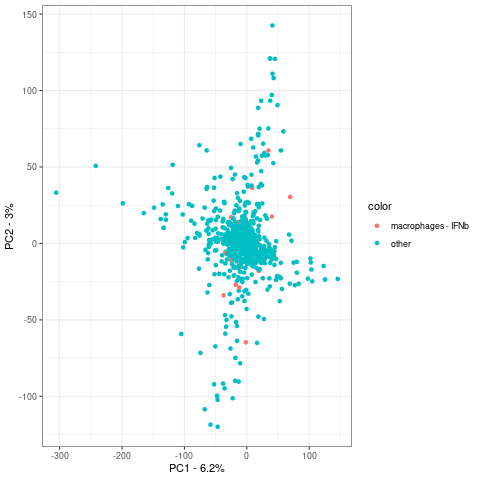

In [77]:
%%R
X = pca$x[,1]
Y = pca$x[,2]
pca_data <- data.frame(Names = rownames(pca$x), + X, + Y)
pca_var <- pca$sdev^2
pca_var_per <- round(pca_var / sum(pca_var) * 100, 1)

df_con = data.frame(index = c('GSE56122-GPL13112_split.txt_1',
                              'GSE56122-GPL13112_split.txt_2',
                              'GSE162620-GPL24247_split.txt_9',
                              'GSE162620-GPL24247_split.txt_10',
                              'GSE162620-GPL24247_split.txt_11',
                              'GSE162620-GPL24247_split.txt_14',
                              'GSE162620-GPL24247_split.txt_15',
                              'GSE162620-GPL24247_split.txt_18',
                              'GSE162620-GPL24247_split.txt_17',
                             'GSE104817-GPL19057_split.txt_9',
                              'GSE104817-GPL19057_split.txt_8',
                              'GSE104817-GPL19057_split.txt_7',
                              'GSE104817-GPL19057_split.txt_6',
                              'GSE104817-GPL19057_split.txt_5',
                              'GSE104817-GPL19057_split.txt_4',
                              'GSE104817-GPL19057_split.txt_3',
                              'GSE104817-GPL19057_split.txt_2',
                             'GSE104817-GPL19057_split.txt_1',
                              'GSE104817-GPL19057_split.txt_10',
                              'GSE104817-GPL19057_split.txt_11',
                              'GSE104817-GPL19057_split.txt_12',
                              'GSE104817-GPL19057_split.txt_13',
                              'GSE104817-GPL19057_split.txt_14',
                              'GSE104817-GPL19057_split.txt_15',
                              'GSE104817-GPL19057_split.txt_16',
                              'GSE104817-GPL19057_split.txt_17'
                             ),
                         color = rep(c('macrophages - IFNb'),times=26))
rownames (df_con)= df_con$index
final <-  merge(pca_data, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")

p <- ggplot(data = final, aes(x = X, y = Y, color=color))
p <- p + geom_point()
p <- p + xlab(paste0("PC1 - ", pca_var_per[1], "%"))
p <- p + ylab(paste0("PC2 - ", pca_var_per[2], "%"))
p <- p + theme_bw()
print(p)

In [84]:
%%R
coor = final[final$color == 'macrophages - IFNb',]
coor = coor[,1-2]
dis2 = dist(coor, method = "euclidean", upper = T, diag = T)
save(dis2,  file = 'dis_macrophages - IFNb.rda')

In [85]:
%%R
summary(dis2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.464  35.709  55.452  64.670  87.895 206.472 


## UMAP 

In [43]:
%%R
df_con = data.frame(index = c('GSE129225-GPL19057_split.txt_1',
                              'GSE115905-GPL19057_split.txt_7',
                              'GSE115905-GPL19057_split.txt_6',
                              'GSE115905-GPL19057_split.txt_5',
                              'GSE115905-GPL19057_split.txt_4',
                              'GSE115905-GPL19057_split.txt_3',
                              'GSE115905-GPL19057_split.txt_2',
                              'GSE115905-GPL19057_split.txt_1'
                              ),
                         color = rep(c('macrophages - TNF'),times=8))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('red', 'blue', 'green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)
coor = final[final$color == 'macrophages - TNF',]
coor = coor[,1-2]
dis2 = dist(coor, method = "euclidean", upper = T, diag = T)
save(dis2,  file = 'dis_macrophages - TNF.rda')

In [13]:
%%R
library(umap)
iris.umap = umap(pca$x, n_components = 2, random_state = 15) 

In [14]:
%%R
library(plotly) 
library(umap) 
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout

fig <- plot_ly(final, x = ~X1, y = ~X2) 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)

R[write to console]: 
Присоединяю пакет: ‘plotly’


R[write to console]: Следующий объект скрыт от ‘package:Hmisc’:

    subplot


R[write to console]: Следующий объект скрыт от ‘package:AnnotationDbi’:

    select


R[write to console]: Следующий объект скрыт от ‘package:IRanges’:

    slice


R[write to console]: Следующий объект скрыт от ‘package:S4Vectors’:

    rename


R[write to console]: Следующий объект скрыт от ‘package:ggplot2’:

    last_plot


R[write to console]: Следующий объект скрыт от ‘package:stats’:

    filter


R[write to console]: Следующий объект скрыт от ‘package:graphics’:

    layout


R[write to console]: No trace type specified:
  Based on info supplied, a 'scatter' trace seems appropriate.
  Read more about this trace type -> https://plotly.com/r/reference/#scatter

R[write to console]: No scatter mode specifed:
  Setting the mode to markers
  Read more about this attribute -> https://plotly.com/r/reference/#scatter-mode



# Теперь покрасим по наличию/отсутствию lps

In [30]:
pwd

'/Users/pavellebedev/Yandex.Disk.localized/Cloud_project/Project_2'

In [31]:
%%R
library(stringr)

In [19]:
%%R
files<-list.files(path='split', pattern='.txt', full.names = FALSE)
df_con =  data.frame()
for (fileName in files) {   
    folder <- file.path("split")
    path = file.path(folder, fileName)
    skip_to_next <- FALSE
    tryCatch({ 
        split <-  read.table(path)
        for (i in 1:nrow(split)) {
            skip_to_next <- FALSE
            tryCatch({    # miss errors and continue, if samplew are not in exp
                con = split[7][i,]
                con2 = split[6][i,]
                if (grepl('lps|LPS', con) == TRUE | grepl('lps|LPS', con2) == TRUE  ){
                    result = 'lps'
                } else {
                    result = 'lps-'
                }
                result = c(paste0(fileName, "`_", i), result)
                df_con = rbind(df_con, result)   
        }, error = function(e) { skip_to_next <<- TRUE})
        if(skip_to_next) { next }
            }
    }, error = function(e) { skip_to_next <<- TRUE})
    if(skip_to_next) { next }
    }


In [20]:
%%R
con

[1] "BMDM_R0A//BMDM_R0B//BMDM_R1A//BMDM_R1B//BMDM_R2A//BMDM_R2B//BMDM_R4A//BMDM_R4B//BMDM_R6A//BMDM_R6B//BMDM_T0A//BMDM_T0B//BMDM_T1A//BMDM_T1B//BMDM_T2A//BMDM_T2B//BMDM_T4A//BMDM_T4B//BMDM_T6A//BMDM_T6B//TTP_CLIP_INPUT"


In [21]:
%%R
res = pca$x

In [22]:
%%R
str(df_con)

'data.frame':	1202 obs. of  2 variables:
 $ X.GSE100067.GPL17021_split.txt._1.: chr  "GSE100067-GPL17021_split.txt`_1" "GSE100067-GPL17021_split.txt`_2" "GSE100067-GPL17021_split.txt`_3" "GSE100316-GPL15103_split.txt`_1" ...
 $ X.lps..                           : chr  "lps-" "lps-" "lps-" "lps-" ...


In [23]:
%%R
df_con[1:3, 1]

[1] "GSE100067-GPL17021_split.txt`_1" "GSE100067-GPL17021_split.txt`_2"
[3] "GSE100067-GPL17021_split.txt`_3"


In [24]:
%%R
df_con2 = df_con[df_con[,1] %in% rownames(layout),]

In [25]:
%%R
rownames(df_con2) = df_con2[,1]

In [26]:
%%R
str(df_con2)

'data.frame':	856 obs. of  2 variables:
 $ X.GSE100067.GPL17021_split.txt._1.: chr  "GSE100067-GPL17021_split.txt`_1" "GSE100067-GPL17021_split.txt`_2" "GSE100316-GPL15103_split.txt`_5" "GSE100495-GPL19057_split.txt`_1" ...
 $ X.lps..                           : chr  "lps-" "lps-" "lps-" "lps-" ...


In [27]:
%%R
str(layout)

'data.frame':	899 obs. of  2 variables:
 $ X1: num  -0.115 -0.845 -2.131 -2.03 -1.049 ...
 $ X2: num  0.3873 0.1634 -0.6728 -0.0125 -0.454 ...


In [28]:
%%R
layout = layout[rownames(layout) %in% df_con2[,1],]

In [29]:
%%R

layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- cbind(layout) 

fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~df_con2, colors = c('#636EFA','#00CC96'), type = 'scatter', mode = 'markers')%>%  
  layout(
    plot_bgcolor = "#e5ecf6",
    legend=list(title=list(text='lps_exposure')), 
    xaxis = list( 
      title = "0"),  
    yaxis = list( 
      title = "1")) 
    fig

In [53]:
%%R
pca = prcomp(df_t, center = FALSE, scale = FALSE, na.action = na.omit)

In [54]:
%%R
library(umap)
iris.umap = umap(pca$x, n_components = 2, random_state = 15) 

In [30]:
%%R
library(plotly) 
library(umap) 
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <-  merge(layout, df_con2,
                          by = 'row.names', all = TRUE)

fig <- plot_ly(final, x = ~X1, y = ~X2, color = final$X.lps.., colors = c('red','blue')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)

In [32]:
%%R
df_con = data.frame(index = c('GSE89184-GPL13112_split.txt`_1',
                              'GSE89184-GPL13112_split.txt`_2',
                              'GSE89184-GPL13112_split.txt`_3',
                              'GSE89184-GPL13112_split.txt`_4',
                              'GSE89184-GPL13112_split.txt`_5',
                              'GSE89184-GPL13112_split.txt`_6',
                              'GSE89184-GPL13112_split.txt`_7',
                              'GSE89184-GPL13112_split.txt`_8',
                              'GSE89184-GPL13112_split.txt`_9',
                              'GSE89184-GPL13112_split.txt`_10',
                              'GSE89184-GPL13112_split.txt`_11',
                              'GSE89184-GPL13112_split.txt`_12'),
                         color = rep(c('macrophages - Legionella Pneumophyla'),times= 12))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('blue','green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)

In [34]:
%%R

df_con = data.frame(index = c('GSE115495-GPL17021_split.txt`_2',
                              'GSE117330-GPL19057_split.txt`_5',
                              'GSE117330-GPL19057_split.txt`_4',
                              'GSE117330-GPL19057_split.txt`_3',
                              'GSE117330-GPL19057_split.txt`_2',
                              'GSE117330-GPL19057_split.txt`_1',
                             'GSE125287-GPL19057_split.txt`_1',
                             'GSE125287-GPL19057_split.txt`_5',
                              'GSE125287-GPL19057_split.txt`_4',
                             'GSE125287-GPL19057_split.txt`_3',
                              'GSE125287-GPL19057_split.txt`_2'
                             ),
                         color = rep(c('cells infected by Mycobacterium tuberculosis'), times = 11))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('red', 'blue', 'green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)

In [15]:
%%R
df_con = data.frame(index = c(#'GSE99046-GPL17021_split.txt_1',
                              #'GSE98168-GPL17021_split.txt_1',
                              #'GSE53053-GPL17021_split.txt_2',
                              #'GSE53053-GPL17021_split.txt_1',
                              # 'GSE179066-GPL21103_split.txt_7',
                              # 'GSE179066-GPL21103_split.txt_5',
                              # 'GSE179066-GPL21103_split.txt_2',
                              # 'GSE179066-GPL21103_split.txt_1',
                              'GSE134158-GPL21103_split.txt_1',
                              'GSE123596-GPL21493_split.txt_7',
                              # 'GSE123596-GPL21493_split.txt_5',
                              'GSE123596-GPL21493_split.txt_3',
                              'GSE123596-GPL21493_split.txt_2',
                              'GSE123596-GPL21493_split.txt_1',
                              'GSE119509-GPL21493_split.txt_9',
                              'GSE119509-GPL21493_split.txt_8',
                              # 'GSE119509-GPL21493_split.txt_7',
                              'GSE119509-GPL21493_split.txt_6',
                              'GSE119509-GPL21493_split.txt_5',
                              'GSE119509-GPL21493_split.txt_4',
                              'GSE119509-GPL21493_split.txt_3',
                              'GSE119509-GPL21493_split.txt_2',
                              'GSE119509-GPL21493_split.txt_1',
                              'GSE116108-GPL21103_split.txt_5',
                              'GSE116108-GPL21103_split.txt_4',
                              'GSE116108-GPL21103_split.txt_3',
                              'GSE116108-GPL21103_split.txt_2',
                              'GSE116108-GPL21103_split.txt_1',
                              'GSE116105-GPL21103_split.txt_2',
                              'GSE116105-GPL21103_split.txt_3',
                              'GSE116105-GPL21103_split.txt_4',
                              'GSE116105-GPL21103_split.txt_5'
                             ),
                         color = rep(c('macrophages - IL-4'),times=22))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('blue', 'green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)

In [22]:
%%R
final[final$color == 'macrophages - IL-4',]

                         Row.names         X1          X2
195 GSE116105-GPL21103_split.txt_2 -2.6950998  0.92563380
196 GSE116105-GPL21103_split.txt_3 -0.2159217  0.26876107
197 GSE116105-GPL21103_split.txt_4 -0.2199473 -0.04760761
198 GSE116105-GPL21103_split.txt_5  0.1857689 -0.74784486
199 GSE116108-GPL21103_split.txt_1 -2.8673930  0.73381022
200 GSE116108-GPL21103_split.txt_2 -2.7303883  0.88887704
201 GSE116108-GPL21103_split.txt_3 -0.1454861  0.39209808
202 GSE116108-GPL21103_split.txt_4 -0.2180229 -0.04514543
203 GSE116108-GPL21103_split.txt_5  0.1502222 -0.72522263
231 GSE119509-GPL21493_split.txt_1 -1.8618889  1.06619293
232 GSE119509-GPL21493_split.txt_2 -1.6259305  1.94744858
233 GSE119509-GPL21493_split.txt_3 -1.8573530  0.72196106
234 GSE119509-GPL21493_split.txt_4 -0.6032968  0.97877037
235 GSE119509-GPL21493_split.txt_5 -1.3117541  0.97354498
236 GSE119509-GPL21493_split.txt_6 -1.2819576  0.62360054
237 GSE119509-GPL21493_split.txt_7 -1.9261998  0.59040929
238 GSE119509-

In [16]:
%%R
coor = final[final$color == 'macrophages - IL-4',]
coor = coor[,1-2]
dis2 = dist(coor, method = "euclidean", upper = T, diag = T)
save(dis2,  file = 'macrophages - IL-4.rda')

In [21]:
%%R
df_con = data.frame(index = c('GSE133026-GPL21103_split.txt_1',
                              'GSE133026-GPL21103_split.txt_2',
                              'GSE133026-GPL21103_split.txt_3',
                              'GSE133026-GPL21103_split.txt_4',
                              'GSE146235-GPL21103_split.txt_2'),
                         color = rep(c('alveolar macrophages infected by Cryptococcus neoformans'), times = 5))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('red', 'green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)
coor = final[final$color == 'alveolar macrophages infected by Cryptococcus neoformans',]
coor = coor[,1-2]
dis2 = dist(coor, method = "euclidean", upper = T, diag = T)
save(dis2,  file = 'alveolar macrophages infected by Cryptococcus neoformans.rda')

In [102]:
%%R
final[final$color == 'alveolar macrophages infected by Cryptococcus neoformans',]

                         Row.names         X1          X2
399 GSE133026-GPL21103_split.txt_1 -1.9415438  0.17275084
400 GSE133026-GPL21103_split.txt_2 -1.5529142 -0.07492432
401 GSE133026-GPL21103_split.txt_3 -0.3603685  0.35975243
402 GSE133026-GPL21103_split.txt_4 -1.9340957  0.02375621
514 GSE146235-GPL21103_split.txt_2 -1.5996164  0.03012161
                             index
399 GSE133026-GPL21103_split.txt_1
400 GSE133026-GPL21103_split.txt_2
401 GSE133026-GPL21103_split.txt_3
402 GSE133026-GPL21103_split.txt_4
514 GSE146235-GPL21103_split.txt_2
                                                       color
399 alveolar macrophages infected by Cryptococcus neoformans
400 alveolar macrophages infected by Cryptococcus neoformans
401 alveolar macrophages infected by Cryptococcus neoformans
402 alveolar macrophages infected by Cryptococcus neoformans
514 alveolar macrophages infected by Cryptococcus neoformans


In [24]:
%%R
df_con = data.frame(index = c('GSE145295-GPL19057_split.txt_5',
                              'GSE145295-GPL19057_split.txt_4',
                              'GSE145295-GPL19057_split.txt_3',
                              'GSE145295-GPL19057_split.txt_2',
                              'GSE145295-GPL19057_split.txt_1'
                              
                              ),
                         color = rep(c('alveolar macrophages - asbestosis'),times=5))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('red', 'blue', 'green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)

In [87]:
%%R
coor = final[final$color == 'alveolar macrophages - asbestosis',]
coor = coor[,1-2]
dis2 = dist(coor, method = "euclidean", upper = T, diag = T)
save(dis2,  file = 'alveolar macrophages - asbestosis.rda')

In [25]:
%%R
df_con = data.frame(index = c('GSE129225-GPL19057_split.txt_1',
                              'GSE115905-GPL19057_split.txt_7',
                              'GSE115905-GPL19057_split.txt_6',
                              'GSE115905-GPL19057_split.txt_5',
                              'GSE115905-GPL19057_split.txt_4',
                              'GSE115905-GPL19057_split.txt_3',
                              'GSE115905-GPL19057_split.txt_2',
                              'GSE115905-GPL19057_split.txt_1'
                              ),
                         color = rep(c('macrophages - TNF'),times=8))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('red', 'blue', 'green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)

In [89]:
%%R
final[final$color == 'macrophages - TNF',]

                         Row.names         X1         X2
181 GSE115905-GPL19057_split.txt_1 -1.2280943  2.1125664
182 GSE115905-GPL19057_split.txt_2  0.4755962  3.1126893
183 GSE115905-GPL19057_split.txt_3  1.2297738  1.6645295
184 GSE115905-GPL19057_split.txt_4  0.6917011  3.0399778
185 GSE115905-GPL19057_split.txt_5 -1.3418028  1.5969198
186 GSE115905-GPL19057_split.txt_6 -1.9566938  1.3428299
187 GSE115905-GPL19057_split.txt_7  1.5563252 -0.2710186
351 GSE129225-GPL19057_split.txt_1 -0.4764026  1.0739634
                             index             color
181 GSE115905-GPL19057_split.txt_1 macrophages - TNF
182 GSE115905-GPL19057_split.txt_2 macrophages - TNF
183 GSE115905-GPL19057_split.txt_3 macrophages - TNF
184 GSE115905-GPL19057_split.txt_4 macrophages - TNF
185 GSE115905-GPL19057_split.txt_5 macrophages - TNF
186 GSE115905-GPL19057_split.txt_6 macrophages - TNF
187 GSE115905-GPL19057_split.txt_7 macrophages - TNF
351 GSE129225-GPL19057_split.txt_1 macrophages - TNF


In [26]:
%%R
coor = final[final$color == 'macrophages - TNF',]
coor = coor[,1-2]
dis2 = dist(coor, method = "euclidean", upper = T, diag = T)
save(dis2,  file = 'macrophages - TNF.rda')

In [31]:
%%R
df_con = data.frame(index = c('GSE136363-GPL21103_split.txt_1',
                              # 'GSE127739-GPL21103_split.txt_5',
                              'GSE127739-GPL21103_split.txt_4',
                              'GSE127739-GPL21103_split.txt_3',
                              'GSE127739-GPL21103_split.txt_2',
                              'GSE127739-GPL21103_split.txt_1'
                              ),
                         color = rep(c('macrophages - VSV virus (vesicular stomatits'),times=5))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('red', 'blue', 'green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)

In [32]:
%%R
coor = final[final$color == 'macrophages - VSV virus (vesicular stomatits',]
coor = coor[,1-2]
dis2 = dist(coor, method = "euclidean", upper = T, diag = T)
save(dis2,  file = 'macrophages - VSV virus (vesicular stomatits.rda')

In [27]:
%%R
df_con = data.frame(index = c('GSE127739-GPL21103_split.txt_1',
                              'GSE127739-GPL21103_split.txt_2',
                              'GSE127739-GPL21103_split.txt_4',
                              'GSE127739-GPL21103_split.txt_3',
                              # 'GSE127739-GPL21103_split.txt_5',
                              'GSE136363-GPL21103_split.txt_1'
                              ),
                         color = c(rep(c('macrophages - VSV virus (vesicular stomatits) - 8-12 hours'),times=2), rep(c('macrophages - VSV virus (vesicular stomatits) - 0 hours'),times=3)))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('red', 'blue', 'green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)

In [92]:
%%R
df_con = data.frame(index = c('GSE56122-GPL13112_split.txt_1',
                              'GSE56122-GPL13112_split.txt_2',
                              'GSE162620-GPL24247_split.txt_9',
                              'GSE162620-GPL24247_split.txt_10',
                              'GSE162620-GPL24247_split.txt_11',
                              'GSE162620-GPL24247_split.txt_14',
                              'GSE162620-GPL24247_split.txt_15',
                              'GSE162620-GPL24247_split.txt_18',
                              'GSE162620-GPL24247_split.txt_17',
                             'GSE104817-GPL19057_split.txt_9',
                              'GSE104817-GPL19057_split.txt_8',
                              'GSE104817-GPL19057_split.txt_7',
                              'GSE104817-GPL19057_split.txt_6',
                              'GSE104817-GPL19057_split.txt_5',
                              'GSE104817-GPL19057_split.txt_4',
                              'GSE104817-GPL19057_split.txt_3',
                              'GSE104817-GPL19057_split.txt_2',
                             'GSE104817-GPL19057_split.txt_1',
                              'GSE104817-GPL19057_split.txt_10',
                              'GSE104817-GPL19057_split.txt_11',
                              'GSE104817-GPL19057_split.txt_12',
                              'GSE104817-GPL19057_split.txt_13',
                              'GSE104817-GPL19057_split.txt_14',
                              'GSE104817-GPL19057_split.txt_15',
                              'GSE104817-GPL19057_split.txt_16',
                              'GSE104817-GPL19057_split.txt_17'
                             ),
                         color = rep(c('macrophages - IFNb'),times=26))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('red', 'blue', 'green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)

In [22]:
%%R

df_con = data.frame(index = c(# 'GSE108581-GPL17021_split.txt_9',
                              'GSE108581-GPL17021_split.txt_8',
                              'GSE108581-GPL17021_split.txt_7',
                              # 'GSE108581-GPL17021_split.txt_6',
                              'GSE108581-GPL17021_split.txt_5',
                              'GSE108581-GPL17021_split.txt_4',
                              'GSE108581-GPL17021_split.txt_3',
                              'GSE108581-GPL17021_split.txt_2',
                              'GSE108581-GPL17021_split.txt_1' 
                              ),
                         color = rep(c('macrophages - LPS + IFN gamma'),times=7))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('blue', 'green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)

In [94]:
%%R
final[final$color == ('macrophages - LPS + IFN gamma'),]

                        Row.names         X1         X2
73 GSE108581-GPL17021_split.txt_1  0.3145178  2.8012154
74 GSE108581-GPL17021_split.txt_2  1.7827788  1.5865526
75 GSE108581-GPL17021_split.txt_3  0.3610880  1.0742582
76 GSE108581-GPL17021_split.txt_4  0.2317045  2.8012481
77 GSE108581-GPL17021_split.txt_5  0.2928869  2.7827652
79 GSE108581-GPL17021_split.txt_7  1.4229121 -0.4470088
80 GSE108581-GPL17021_split.txt_8  1.0397185  2.1841748
81 GSE108581-GPL17021_split.txt_9 -2.4446070 -2.1640698
                            index                         color
73 GSE108581-GPL17021_split.txt_1 macrophages - LPS + IFN gamma
74 GSE108581-GPL17021_split.txt_2 macrophages - LPS + IFN gamma
75 GSE108581-GPL17021_split.txt_3 macrophages - LPS + IFN gamma
76 GSE108581-GPL17021_split.txt_4 macrophages - LPS + IFN gamma
77 GSE108581-GPL17021_split.txt_5 macrophages - LPS + IFN gamma
79 GSE108581-GPL17021_split.txt_7 macrophages - LPS + IFN gamma
80 GSE108581-GPL17021_split.txt_8 macrophages - 

In [23]:
%%R
coor = final[final$color == 'macrophages - LPS + IFN gamma',]
coor = coor[,1-2]
dis2 = dist(coor, method = "euclidean", upper = T, diag = T)
save(dis2,  file = 'macrophages - LPS + IFN gamma.rda')

In [17]:
%%R
df_con = data.frame(index = c('GSE89184-GPL13112_split.txt_1',
                              'GSE89184-GPL13112_split.txt_2',
                              'GSE89184-GPL13112_split.txt_3',
                              'GSE89184-GPL13112_split.txt_4',
                              'GSE89184-GPL13112_split.txt_5',
                              'GSE89184-GPL13112_split.txt_6',
                              'GSE89184-GPL13112_split.txt_7',
                              'GSE89184-GPL13112_split.txt_8',
                              # 'GSE89184-GPL13112_split.txt_9',
                              # 'GSE89184-GPL13112_split.txt_10',
                              'GSE89184-GPL13112_split.txt_11'
                              # 'GSE89184-GPL13112_split.txt_12',
                             ),
                         color = rep(c('macrophages - Legionella Pneumophyla'),times= 9))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('blue','green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)

In [27]:
%%R
final[final$color == 'macrophages - Legionella Pneumophyla',]

                         Row.names         X1          X2
797  GSE89184-GPL13112_split.txt_1  1.8482340  0.44529478
799 GSE89184-GPL13112_split.txt_11  1.9202575 -2.84073763
801  GSE89184-GPL13112_split.txt_2  1.7242575  0.12438106
802  GSE89184-GPL13112_split.txt_3  1.2164723  0.35476487
803  GSE89184-GPL13112_split.txt_4 -0.4257534  3.22124375
804  GSE89184-GPL13112_split.txt_5  2.1045016  0.55598091
805  GSE89184-GPL13112_split.txt_6  2.2917997  0.08144788
806  GSE89184-GPL13112_split.txt_7  1.9219781  0.23049049
807  GSE89184-GPL13112_split.txt_8  1.8389354  0.34528472
                             index                                color
797  GSE89184-GPL13112_split.txt_1 macrophages - Legionella Pneumophyla
799 GSE89184-GPL13112_split.txt_11 macrophages - Legionella Pneumophyla
801  GSE89184-GPL13112_split.txt_2 macrophages - Legionella Pneumophyla
802  GSE89184-GPL13112_split.txt_3 macrophages - Legionella Pneumophyla
803  GSE89184-GPL13112_split.txt_4 macrophages - Legionella 

In [18]:
%%R
coor = final[final$color == 'macrophages - Legionella Pneumophyla',]
coor = coor[,1-2]
dis2 = dist(coor, method = "euclidean", upper = T, diag = T)
save(dis2,  file = 'macrophages - Legionella Pneumophyla.rda')

In [19]:
%%R

df_con = data.frame(index = c('GSE115495-GPL17021_split.txt_2',
                              'GSE117330-GPL19057_split.txt_5',
                              'GSE117330-GPL19057_split.txt_4',
                              'GSE117330-GPL19057_split.txt_3',
                              'GSE117330-GPL19057_split.txt_2',
                              'GSE117330-GPL19057_split.txt_1',
                             'GSE125287-GPL19057_split.txt_1',
                             'GSE125287-GPL19057_split.txt_5',
                              'GSE125287-GPL19057_split.txt_4',
                             'GSE125287-GPL19057_split.txt_3',
                              'GSE125287-GPL19057_split.txt_2'
                             ),
                         color = rep(c('cells infected by Mycobacterium tuberculosis'), times = 11))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('red', 'blue', 'green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)

In [20]:
%%R
coor = final[final$color == 'cells infected by Mycobacterium tuberculosis',]
coor = coor[,1-2]
dis2 = dist(coor, method = "euclidean", upper = T, diag = T)
save(dis2,  file = 'cells infected by Mycobacterium tuberculosis.rda')

In [33]:
%%R
df_con = data.frame(index = c('GSE56122-GPL13112_split.txt_1',
                              'GSE56122-GPL13112_split.txt_2',
                              'GSE162620-GPL24247_split.txt_9',
                              'GSE162620-GPL24247_split.txt_10',
                              'GSE162620-GPL24247_split.txt_11',
                              'GSE162620-GPL24247_split.txt_14',
                              'GSE162620-GPL24247_split.txt_15',
                              'GSE162620-GPL24247_split.txt_18',
                              'GSE162620-GPL24247_split.txt_17',
                             'GSE104817-GPL19057_split.txt_9',
                              'GSE104817-GPL19057_split.txt_8',
                              'GSE104817-GPL19057_split.txt_7',
                              'GSE104817-GPL19057_split.txt_6',
                              'GSE104817-GPL19057_split.txt_5',
                              'GSE104817-GPL19057_split.txt_4',
                              'GSE104817-GPL19057_split.txt_3',
                              'GSE104817-GPL19057_split.txt_2',
                             'GSE104817-GPL19057_split.txt_1',
                              'GSE104817-GPL19057_split.txt_10',
                              'GSE104817-GPL19057_split.txt_11',
                              'GSE104817-GPL19057_split.txt_12',
                              'GSE104817-GPL19057_split.txt_13',
                              'GSE104817-GPL19057_split.txt_14',
                              'GSE104817-GPL19057_split.txt_15',
                              'GSE104817-GPL19057_split.txt_16',
                              'GSE104817-GPL19057_split.txt_17'
                             ),
                         color = rep(c('macrophages - IFNb'),times=26))
rownames (df_con)= df_con$index
layout <- iris.umap[["layout"]] 
layout <- data.frame(layout) 
final <- layout
final <-  merge(layout, df_con,
                          by = 'row.names', all = TRUE)
final$color = replace(final$color, is.na(final$color), "other")
fig <- plot_ly(final, x = ~X1, y = ~X2, color = ~ color, colors = c('red', 'blue', 'green')) 
fig <- fig %>% add_markers() 
fig <- fig %>% layout(scene = list(xaxis = list(title = '0'), 
                                     yaxis = list(title = '1'))) 

print(fig)